In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from lbm_core import LBMSolver
from boundaries import TunnelBoundaries
from analysis import plot_complexity_dashboard
from aerodynamics import calculate_lift_drag, check_ground_effect


In [ ]:
# --- CONFIGURATION ---
NX, NY = 500, 200
REYNOLDS = 10000        # High Re to force turbulence
GROUND_TYPE = "no_slip" 

# --- SETUP ---
print(f"Initializing Virtual Wind Tunnel (Re={REYNOLDS}, Ground={GROUND_TYPE})...")
solver = LBMSolver(NX, NY, REYNOLDS, u_inlet=0.1)
bounds = TunnelBoundaries(NX, NY)

bounds.add_ground(type=GROUND_TYPE)
bounds.add_f1_wing_proxy(
    x_pos=50,
    height=80,
    length=40,
    slope=0.5
)


In [ ]:
# --- HISTORY LISTS (For the Plot) ---
drag_history = []
lift_history = []
step_history = []

# --- MAIN LOOP ---
print("Starting Simulation...")
TOTAL_STEPS = 3000

for step in range(TOTAL_STEPS + 1):
    
    # 1. PHYSICS
    solver.collide_and_stream(bounds.mask)
    bounds.apply_inlet_outlet(solver)
    
    # 2. AERO MONITOR & LOGGING
    if step % 100 == 0:
        fx, fy = calculate_lift_drag(solver, bounds)
        check_ground_effect(fx, fy)
        print(f"Step {step}/{TOTAL_STEPS}")
        
        # Save for plotting
        drag_history.append(fx)
        lift_history.append(fy)
        step_history.append(step)
        
    # 3. COMPLEXITY DASHBOARD
    if step > 0 and step % 500 == 0:
        print(f"   --> Displaying Complexity Dashboard (Step {step})...")
        plot_complexity_dashboard(solver, step)



In [ ]:
# --- FINAL VISUALIZATION 1: FLOW FIELD ---
print("Simulation Complete. Saving Visualizations...")

plt.figure(figsize=(12, 5), dpi=150)
velocity_mag = np.sqrt(solver.u[:,:,0]**2 + solver.u[:,:,1]**2)
velocity_mag[bounds.mask] = np.nan 
plt.imshow(velocity_mag, origin='lower', cmap='magma')
plt.colorbar(label="Flow Velocity |u|")
plt.title(f"Final Flow State (Re={REYNOLDS})")
plt.savefig("final_flow.png")
plt.show()


In [ ]:
# --- FINAL VISUALIZATION 2: AERO FORCES (NEW!) ---
plt.figure(figsize=(10, 5), dpi=100)
plt.plot(step_history, drag_history, 'r-', label='Drag (Fx)')
plt.plot(step_history, lift_history, 'b-', label='Lift (Fy)')
plt.axhline(0, color='black', linestyle='--', alpha=0.5) # Zero line
plt.xlabel("Simulation Step")
plt.ylabel("Force (LBM Units)")
plt.title(f"Aerodynamic Load History\n(Negative Lift = Downforce)")
plt.legend()
plt.grid(True, alpha=0.3)
plt.savefig("aero_forces_history.png") # Send this to your group!
print("Saved 'aero_forces_history.png'.")
plt.show()

Initializing Simulation for Video Rendering...
Starting Render... (This might take a minute)
Rendering Frame 0/100
Rendering Frame 0/100
Rendering Frame 10/100
Rendering Frame 20/100
Rendering Frame 30/100
Rendering Frame 40/100
Rendering Frame 50/100
Rendering Frame 60/100
Rendering Frame 70/100
Rendering Frame 80/100
Rendering Frame 90/100
Done! Saved 'f1_turbulence_simulation.gif'
Rendering Frame 0/100


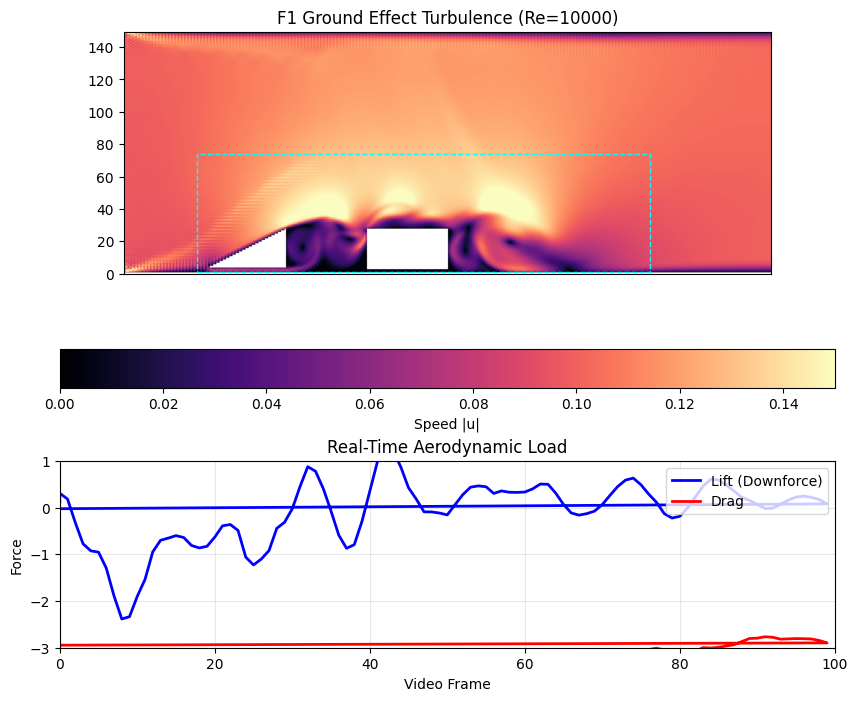

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
import matplotlib.patches as patches
from lbm_core import LBMSolver
from boundaries import TunnelBoundaries
from aerodynamics import calculate_lift_drag

# --- CONFIGURATION ---
NX, NY = 400, 150
REYNOLDS = 10000        # High speed turbulence
FRAMES = 100            # Total video frames
STEPS_PER_FRAME = 20    # Speed up factor (sim steps per video frame)

# --- SETUP SIMULATION ---
print("Initializing Simulation for Video Rendering...")
solver = LBMSolver(NX, NY, REYNOLDS, u_inlet=0.1)
bounds = TunnelBoundaries(NX, NY)
bounds.add_ground(type="no_slip")
bounds.add_f1_wing_proxy(
    x_pos=50,
    height=3,
    length=50,
    slope=0.5
)
bounds.add_rectangular_obstacle(
    x_start=150,
    y_start=3,
    length=50,
    height=25
)

relevant_x_start = 45
relevant_x_end = 325
relevant_y_start = 1
relevant_y_end = 74

# --- SETUP PLOTS ---
fig = plt.figure(figsize=(10, 8), dpi=100)
gs = fig.add_gridspec(2, 1, height_ratios=[2, 1])

# Plot 1: The Flow (Top)
ax_flow = fig.add_subplot(gs[0])
# Initialize with zero velocity
velocity_mag = np.zeros((NY, NX))
velocity_mag[bounds.mask] = np.nan
im_flow = ax_flow.imshow(velocity_mag, origin='lower', cmap='magma', vmin=0, vmax=0.15)
ax_flow.set_title(f"F1 Ground Effect Turbulence (Re={REYNOLDS})")
ax_flow.set_xticks([]) # Hide x-axis for cleaner look
ax_flow.add_patch(
    patches.Rectangle(
        (relevant_x_start, relevant_y_start), relevant_x_end - relevant_x_start, relevant_y_end - relevant_y_start,
        linewidth=1, edgecolor='cyan', facecolor='none', linestyle='--'
    )
)
plt.colorbar(im_flow, ax=ax_flow, label="Speed |u|", orientation="horizontal", pad=0.2)

# Plot 2: The Force Monitor (Bottom)
ax_force = fig.add_subplot(gs[1])
line_lift, = ax_force.plot([], [], 'b-', linewidth=2, label='Lift (Downforce)')
line_drag, = ax_force.plot([], [], 'r-', linewidth=2, label='Drag')
ax_force.set_xlim(0, FRAMES)
ax_force.set_ylim(-3.0, 1.0) # Adjust based on your previous logs
ax_force.set_xlabel("Video Frame")
ax_force.set_ylabel("Force")
ax_force.legend(loc="upper right")
ax_force.grid(True, alpha=0.3)
ax_force.set_title("Real-Time Aerodynamic Load")

# Data containers
lift_data = []
drag_data = []
frame_indices = []

def update(frame):
    # Run physics steps
    for _ in range(STEPS_PER_FRAME):
        solver.collide_and_stream(bounds.mask)
        bounds.apply_inlet_outlet(solver)
    
    # Calculate Aero
    fx, fy = calculate_lift_drag(
        solver,
        bounds,
        x_start=relevant_x_start,
        x_end=relevant_x_end,
        y_start=relevant_y_start,
        y_end=relevant_y_end
    )
    
    # Update Data
    lift_data.append(fy)
    drag_data.append(fx)
    frame_indices.append(frame)
    
    # Update Flow Image
    v_mag = np.sqrt(solver.u[:,:,0]**2 + solver.u[:,:,1]**2)
    v_mag[bounds.mask] = np.nan
    im_flow.set_array(v_mag)
    
    # Update Force Lines
    line_lift.set_data(frame_indices, lift_data)
    line_drag.set_data(frame_indices, drag_data)
    
    if frame % 10 == 0:
        print(f"Rendering Frame {frame}/{FRAMES}")
    
    return im_flow, line_lift, line_drag

print("Starting Render... (This might take a minute)")
anim = FuncAnimation(fig, update, frames=FRAMES, interval=50, blit=False)

# Save as MP4
anim.save('f1_turbulence_simulation.gif', writer='pillow', fps=20)
print("Done! Saved 'f1_turbulence_simulation.gif'")